# Aufgabe 2.6 - Zweidimensionale, stationäre Potentialströmung

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
np.set_printoptions(linewidth=150)

Hilfsfunktionen: Zuordnung 2D-1D-Mapping, Abstand zwischen Punkt und finiter Linie (für Zuordnung der RBen)

In [2]:
def dist_finite(x1, y1, x2, y2, x3, y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1
    norm = px*px + py*py
    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)
    if u > 1:
        u = 1
    elif u < 0:
        u = 0
    x = x1 + u * px
    y = y1 + u * py
    dx = x - x3
    dy = y - y3
    dist = (dx*dx + dy*dy)
    return dist
def rectangular_mesh(L, H, n_x, n_y):
    mesh = []
    for i in np.linspace(0, L, n_x):
        for j in np.linspace(0, H, n_y):
            mesh += [[i, j]]
    return mesh
def index_to_i_j(index, n_x, n_y):
    n_x = int(index/n_y)
    n_y = index % n_y
    return [n_x, n_y]
def i_j_to_index(i, j, n_x, n_y):
    return i * n_y + j


Randbedingungs-Klasse für 2D-Probleme abgewandelt

`line_neumann` wendet eine Randbedingung auf alle Mesh-Punkte auf einer finiten Linie an.

In [3]:
class rb():
    position_x = 10
    position_y = 10
    def __init__(self, position_x, position_y):
        self.position_x = position_x
        self.position_y = position_y
    def apply(self, mesh, systemmatrix, rhs, delta_x):
        pass
class neumann(rb):
    fluss = 5
    def __init__(self, position_x, position_y, fluss):
        super(neumann,self).__init__(position_x, position_y)
        self.fluss = fluss
    def apply(self, mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y):
        if (self.position_x < 0 or self.position_x >= n_x or self.position_y < 0 or self.position_y >= n_y):
            raise ValueError("Out of bounds")
        # obere oder untere Grenze?
        vertikal = False
        if (self.position_y == 0 or self.position_y == n_y - 1):
            vertikal = True
        position = 0;
        if (self.position_y == 0):
            position = i_j_to_index(self.position_x, 1, n_x, n_y)
        elif (self.position_y == n_y - 1):
            position = i_j_to_index(self.position_x, n_y - 2, n_x, n_y)
        elif (self.position_x == 0):
            position = i_j_to_index(1, self.position_y, n_x, n_y)
        elif (self.position_x == n_x - 1):
            position = i_j_to_index(n_x - 2, self.position_y, n_x, n_y)
        else:
            raise ValueError("Not on boundary")
        main_index = i_j_to_index(self.position_x, self.position_y, n_x, n_y)
        divisor = (delta_y if vertikal else delta_x)
        #print("Second index: {}".format(index_to_i_j(position, n_x, n_y)))
        #print("Setting entries ({}, {}) and ({}, {})".format(main_index, main_index, main_index, position))
        systemmatrix[main_index, position] = -1 / divisor
        systemmatrix[main_index, main_index] = 1 / divisor
        rhs[main_index] = self.fluss
class dirichlet(rb):
    stromfunktion = 150
    def __init__(self, position_x, position_y, stromfunktion):
        super(dirichlet,self).__init__(position_x, position_y)
        self.stromfunktion = stromfunktion
    def apply(self, mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y):
        if (self.position_x < 0 or self.position_x >= n_x or self.position_y < 0 or self.position_y >= n_y):
            raise ValueError("Out of bounds")
        pos = i_j_to_index(self.position_x, self.position_y, n_x, n_y)
        systemmatrix[pos, :] = np.zeros((n_x * n_y))
        systemmatrix[pos, pos] = 1
        rhs[pos] = self.stromfunktion
class line_neumann():
    start_x = 0
    start_y = 0
    end_x = 10
    end_y = 10
    fluss = 5
    def __init__(self, position_x, position_y, fluss):
        self.start_x = position_x[0]
        self.end_x = position_x[1]
        self.start_y = position_y[0]
        self.end_y = position_y[1]
        self.fluss = fluss
    def apply(self, mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y):
        rben = []
        for i in range(len(mesh)):
            point=mesh[i]
            dist = dist_finite(self.start_x, self.start_y, self.end_x, self.end_y, point[0], point[1])
            if dist < 0.001:
                pos = index_to_i_j(i, n_x, n_y)
                randb = neumann(pos[0], pos[1], self.fluss)
                #print("Located Point on BC: indices ({}, {})".format(randb.position_x, randb.position_y))
                randb.apply(mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y)

### Aufgabe 2.6.1 
Problem-Setup

In [4]:
L = 10
H = 5
n_x = 51
n_y = 51
delta_x = L / (n_x - 1)
delta_y = H / (n_y - 1)
mesh = rectangular_mesh(L, H, n_x, n_y)
systemmatrix = np.zeros((n_x * n_y , n_x * n_y))

### Aufgabe 2.6.2

Randbedingungen

In [11]:
rhs = np.zeros((n_x * n_y))
rbs = [line_neumann((0, 0), (0, H/4), 0), line_neumann((0, 0), (H/4, H/2), -10), line_neumann((0, 0), (H/2, H), 0), 
       line_neumann((L, L), (0, H/2), 0), line_neumann((L, L), (H/2, 3*H/4), 10), line_neumann((L, L), (3*H/4, H), 0), 
       line_neumann((0, L), (H, H), 0), line_neumann((0, L), (0, 0), 0) ]
for rb in rbs:
    rb.apply(mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y)
    pass

### Aufgabe 2.6.3
Der Punkt (1, 1) wird mit einer Dirichlet-RB versehen:

In [12]:
rw = dirichlet(1, 1, 150)

### Aufgabe 2.6.4

Matrix mit Zentraldifferenzen auffüllen:

In [13]:
for i in range(len(mesh)):
    coords = mesh[i]
    pos = index_to_i_j(i, n_x, n_y)
    if (pos[0] == 0 or pos[0] == n_x - 1 or pos[1] == 0 or pos[1] == n_y - 1):
        continue
        # Randpunkt
    # horizontale Ableitung
    west = i_j_to_index(pos[0] - 1, pos[1], n_x, n_y)
    ost = i_j_to_index(pos[0] + 1, pos[1], n_x, n_y)
    systemmatrix[i, west] = systemmatrix[i, west] - 1 / delta_x**2
    systemmatrix[i, ost] = systemmatrix[i, ost] - 1 / delta_x **2
    systemmatrix[i, i] = systemmatrix[i, i] + 2 / delta_x ** 2
    # vertikale Ableitung
    sued = i_j_to_index(pos[0], pos[1] - 1, n_x, n_y)
    nord = i_j_to_index(pos[0], pos[1] + 1, n_x, n_y)
    systemmatrix[i, sued] = systemmatrix[i, sued] - 1 / delta_y **2
    systemmatrix[i, nord] = systemmatrix[i, nord] - 1 / delta_y **2
    systemmatrix[i, i] = systemmatrix[i, i] + 2 / delta_y ** 2
    #print("Set gradient for point {}, index {}. North: {}, East: {}, South: {}, West: {}".format(pos, i, nord, ost, sued, west));
rw.apply(mesh, systemmatrix, rhs, delta_x, delta_y, n_x, n_y)

### Aufgabe 2.6.5
Lösung und Darstellung der Ergebnisse

In [14]:
result = np.linalg.solve(systemmatrix, rhs)

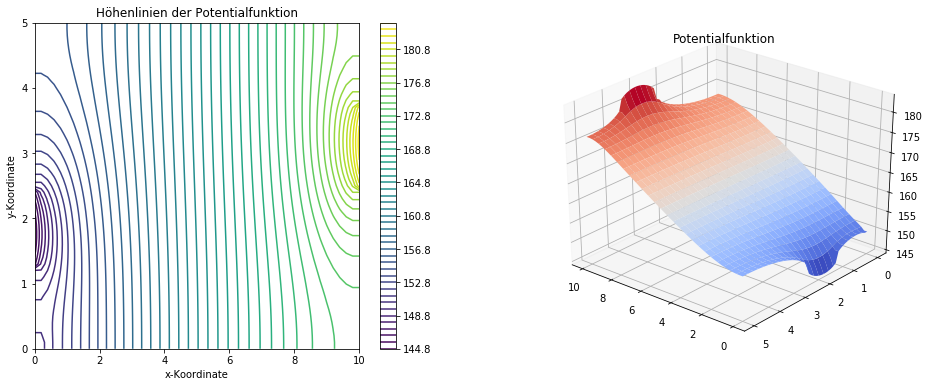

In [17]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1)

plt.title("Höhenlinien der Potentialfunktion")
plt.xlabel("x-Koordinate")
plt.ylabel("y-Koordinate")
xv, yv = np.linspace(0, L, n_x), np.linspace(0, H, n_y)
x2, y2 = np.meshgrid(xv, yv)
plt.contour(np.linspace(0, L, n_x), np.linspace(0, H, n_y), result.reshape((n_y, n_x), order='F'), 50)
plt.colorbar()

ax = fig.add_subplot(1, 2, 2, projection='3d')
z2 = griddata(mesh, result, (x2, y2), method='cubic')
ax.view_init(elev=30., azim=130)
ax.plot_surface(x2, y2, z2, cmap=cm.coolwarm)
plt.title("Potentialfunktion")
plt.show()

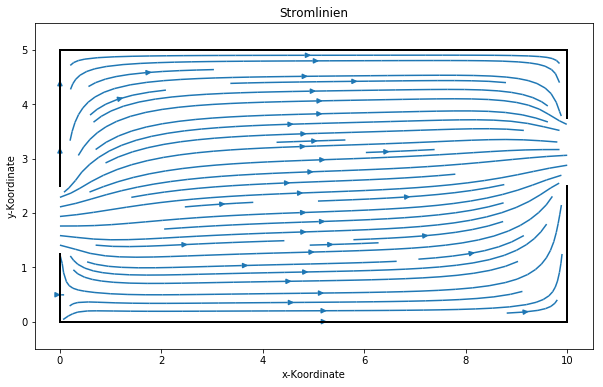

In [16]:
plt.figure(figsize=(10, 6))
u, v = np.gradient(result.reshape((n_y, n_x), order='F'))
plt.streamplot(np.linspace(0, L, n_x), np.linspace(0, H, n_y), v, u)
plt.gca().set_xlim([-0.5, L+0.5])
plt.gca().set_ylim([-0.5, H+0.5])
plt.plot([0, 0], [0, H/4], 'k', alpha=1, linewidth=2)
plt.plot([0, 0], [H/2, H], 'k', alpha=1, linewidth=2)
plt.plot([L, L], [0, H/2], 'k', alpha=1, linewidth=2)
plt.plot([L, L], [3*H/4, H], 'k', alpha=1, linewidth=2)
plt.plot([0, L], [0, 0], 'k', alpha=1, linewidth=2)
plt.plot([0, L], [H, H], 'k', alpha=1, linewidth=2)
plt.title("Stromlinien")
plt.xlabel("x-Koordinate")
plt.ylabel("y-Koordinate")
plt.show()